# <i>Question8</i> --Training for digit 0 to 4

## Load framework

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from datetime import datetime
import os
from time import clock

## Set up matplotlib

In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

## Load datasets

In [6]:
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)
X_train = mnist.train.images
y_train = mnist.train.labels
X_test = mnist.test.images
y_test = mnist.test.labels
X_valid = mnist.validation.images
y_valid = mnist.validation.labels

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [7]:
ind_04_train = (np.argmax(y_train, axis=1) <= 4)
ind_04_test = (np.argmax(y_test, axis=1) <= 4)
ind_04_valid = (np.argmax(y_valid, axis=1) <= 4)
X_train_04 = X_train[ind_04_train]
y_train_04 = np.delete(y_train[ind_04_train], [5,6,7,8,9], axis=1)
X_test_04 = X_test[ind_04_test]
y_test_04 = np.delete(y_test[ind_04_test], [5,6,7,8,9], axis=1)
X_valid_04 = X_valid[ind_04_valid]
y_valid_04 = np.delete(y_valid[ind_04_valid], [5,6,7,8,9], axis=1)

#### Check data

In [8]:
print(len(mnist.train.images))
print(len(mnist.test.images))
print(len(mnist.validation.images))
print(y_train_04.shape)

55000
10000
5000
(28038, 5)


#### Load a image

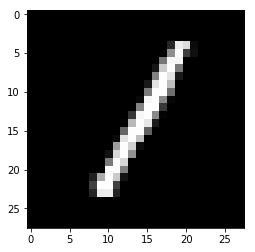

1


In [9]:
some_index = 50000
some_digit = mnist.train.images[some_index]

plt.imshow(some_digit.reshape(28, 28), cmap="gray")
plt.show()
print(np.argmax(mnist.train.labels[some_index]))

## \*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*
## First iteration

In [136]:
iter_ind=1

### define some variables

In [137]:
train_size = mnist.train.num_examples
n_epoch = 50
batch_size = 200

n_feature = mnist.train.images.shape[1]
n_neuron = {"n_hidden{}".format(i) : 100 for i in range(6)}
n_label = mnist.train.labels.shape[1]
n_label_04 = 5

d_dtype=tf.float64

### first define some common functions

In [138]:
from functools import partial

In [139]:
def my_dnn_layer(activation=None, 
                 kernel_initializer=tf.contrib.layers.variance_scaling_initializer()):
    return partial(tf.layers.dense, activation=activation)

In [140]:
def get_batch(X, y, batch_size, epoch, batch):
    num_inst = X.shape[0]
    np.random.seed(epoch * batch * np.random.randint(100))
    shuffle_index = np.random.randint(num_inst, size=batch_size)
    return X[shuffle_index], y[shuffle_index]

#### Build DNN

In [141]:
tf.reset_default_graph()

In [142]:
X_04 = tf.placeholder(dtype=d_dtype, shape=(None, n_feature), name="X_04")
y_04 = tf.placeholder(dtype=d_dtype, shape=(None, n_label_04), name="y_04")

In [143]:
selu_layer = my_dnn_layer(activation=tf.nn.selu)
linear_layer = my_dnn_layer(activation=None)

with tf.name_scope("dnn"):
    hidden1 = selu_layer(X_04, n_neuron["n_hidden1"], name="hidden1")
    hidden2 = selu_layer(hidden1, n_neuron["n_hidden2"], name="hidden2")
    hidden3 = selu_layer(hidden2, n_neuron["n_hidden3"], name="hidden3")
    hidden4 = selu_layer(hidden3, n_neuron["n_hidden4"], name="hidden4")
    hidden5 = selu_layer(hidden4, n_neuron["n_hidden5"], name="hidden5")
    logits = linear_layer(hidden5, n_label_04, name="logits")

In [144]:
with tf.name_scope("loss"):
    xentropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_04, logits=logits, name="xentropy")
    loss = tf.reduce_mean(xentropy, name="loss")

In [145]:
with tf.name_scope("eval"):
    true_labels = tf.argmax(y_04, axis=1)
    y_pred = tf.argmax(logits, axis=1)
    all_acc, acc = tf.metrics.accuracy(labels=true_labels, predictions=y_pred)

In [146]:
with tf.name_scope("train"):
    adam_optimizer = tf.train.AdamOptimizer()
    train_op = adam_optimizer.minimize(loss)

In [148]:
time_now = datetime.now().strftime("%Y%m%d%H%M%S")
base_dir = os.path.join("temp", str(iter_ind))
save_dir = os.path.join(base_dir, time_now, "saves")
log_dir = os.path.join(base_dir, time_now, "logs")

with tf.name_scope("savNlog"):
    saver = tf.train.Saver()
    file_writer = tf.summary.FileWriter(log_dir) # Need to add the graph
    train_acc_log = tf.summary.scalar("train_accuracy", acc)
    validation_acc_log = tf.summary.scalar("validation_accuracy", acc)

In [149]:
with tf.name_scope("initializer"):
    inits = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

In [150]:
with tf.Session() as sess:
    sess.run(inits)
    file_writer.add_graph(tf.get_default_graph())
    tf.train.start_queue_runners(sess=sess)
    for epoch in range(1, n_epoch+1):
        for batch in range(1, np.ceil(train_size/batch_size).astype(int)+1):
            X_batch, y_batch =  get_batch(X_train_04, y_train_04, batch_size, epoch, batch)
            sess.run(train_op, feed_dict={X_04: X_batch, y_04: y_batch})
        if not epoch % 5:
            train_acc, log_train = sess.run([acc, train_acc_log], 
                                            feed_dict={X_04: X_batch, y_04: y_batch})
            val_acc, log_val = sess.run([acc, validation_acc_log],
                                        feed_dict={X_04: X_valid_04, y_04: y_valid_04})
            file_writer.add_summary(log_train, epoch)
            file_writer.add_summary(log_val, epoch)
            print("epoch: {:<3}Training accuracy: {:<6.4f}, \nValidation accuracy: {:<6.4f}"
                  .format(epoch, train_acc, val_acc))
            if not epoch % 10:
                save_file_path = saver.save(sess, os.path.join(save_dir, "{}.ckpt".format(epoch//10)))
                
    file_writer.close()

epoch: 5  Training accuracy: 0.9950, 
Validation accuracy: 0.9880
epoch: 10 Training accuracy: 0.9888, 
Validation accuracy: 0.9889
epoch: 15 Training accuracy: 0.9893, 
Validation accuracy: 0.9906
epoch: 20 Training accuracy: 0.9908, 
Validation accuracy: 0.9915
epoch: 25 Training accuracy: 0.9916, 
Validation accuracy: 0.9916
epoch: 30 Training accuracy: 0.9917, 
Validation accuracy: 0.9917
epoch: 35 Training accuracy: 0.9918, 
Validation accuracy: 0.9918
epoch: 40 Training accuracy: 0.9919, 
Validation accuracy: 0.9919
epoch: 45 Training accuracy: 0.9920, 
Validation accuracy: 0.9920
epoch: 50 Training accuracy: 0.9921, 
Validation accuracy: 0.9921


### Test the result on test set

In [151]:
with tf.Session() as sess:
    inits.run()
    saver.restore(sess, save_file_path)
    acc_test = sess.run(acc, feed_dict={X_04: X_test_04, y_04: y_test_04})
    print("Accuracy for test set is: {:>4.4f}".format(acc_test))

INFO:tensorflow:Restoring parameters from temp/1/20180119013331/saves/5.ckpt
Accuracy for test set is: 0.9957


## \*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*
## Second iteration

In [152]:
iter_ind = 2

<Strong>Change</Strong>
<ol>
    <li>changed neuron per layer to 150
    </li>
    <li>changed activation function to elu for comparison
    </li>
</ol>

### define some variables

In [163]:
train_size = mnist.train.num_examples
n_epoch = 50
batch_size = 200

n_feature = mnist.train.images.shape[1]
n_neuron = {"n_hidden{}".format(i) : 150 for i in range(6)}
n_label = mnist.train.labels.shape[1]
n_label_04 = 5

d_dtype=tf.float64

### define some common functions

In [164]:
from functools import partial

def my_dnn_layer(activation=None, 
                 kernel_initializer=tf.contrib.layers.variance_scaling_initializer()):
    return partial(tf.layers.dense, activation=activation)

In [165]:
def get_batch(X, y, batch_size, epoch, batch):
    num_inst = X.shape[0]
    np.random.seed(epoch * batch * np.random.randint(100))
    shuffle_index = np.random.randint(num_inst, size=batch_size)
    return X[shuffle_index], y[shuffle_index]

#### Build DNN

In [166]:
tf.reset_default_graph()

In [167]:
X_04 = tf.placeholder(dtype=d_dtype, shape=(None, n_feature), name="X_04")
y_04 = tf.placeholder(dtype=d_dtype, shape=(None, n_label_04), name="y_04")

In [168]:
elu_layer = my_dnn_layer(activation=tf.nn.elu)
linear_layer = my_dnn_layer(activation=None)

with tf.name_scope("dnn"):
    hidden1 = elu_layer(X_04, n_neuron["n_hidden1"], name="hidden1")
    hidden2 = elu_layer(hidden1, n_neuron["n_hidden2"], name="hidden2")
    hidden3 = elu_layer(hidden2, n_neuron["n_hidden3"], name="hidden3")
    hidden4 = elu_layer(hidden3, n_neuron["n_hidden4"], name="hidden4")
    hidden5 = elu_layer(hidden4, n_neuron["n_hidden5"], name="hidden5")
    logits = linear_layer(hidden5, n_label_04, name="logits")

In [169]:
with tf.name_scope("loss"):
    xentropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_04, logits=logits, name="xentropy")
    loss = tf.reduce_mean(xentropy, name="loss")

In [170]:
with tf.name_scope("eval"):
    true_labels = tf.argmax(y_04, axis=1)
    y_pred = tf.argmax(logits, axis=1)
    all_acc, acc = tf.metrics.accuracy(labels=true_labels, predictions=y_pred)

In [171]:
with tf.name_scope("train"):
    adam_optimizer = tf.train.AdamOptimizer()
    train_op = adam_optimizer.minimize(loss)

In [173]:
time_now = datetime.now().strftime("%Y%m%d%H%M%S")
base_dir = os.path.join("temp", str(iter_ind))
save_dir = os.path.join(base_dir, time_now, "saves")
log_dir = os.path.join(base_dir, time_now, "logs")

with tf.name_scope("savNlog"):
    saver = tf.train.Saver()
    file_writer = tf.summary.FileWriter(log_dir) # Need to add the graph
    train_acc_log = tf.summary.scalar("train_accuracy", acc)
    validation_acc_log = tf.summary.scalar("validation_accuracy", acc)

In [174]:
with tf.name_scope("initializer"):
    inits = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

In [175]:
with tf.Session() as sess:
    sess.run(inits)
    file_writer.add_graph(tf.get_default_graph())
    tf.train.start_queue_runners(sess=sess)
    for epoch in range(1, n_epoch+1):
        for batch in range(1, np.ceil(train_size/batch_size).astype(int)+1):
            X_batch, y_batch =  get_batch(X_train_04, y_train_04, batch_size, epoch, batch)
            sess.run(train_op, feed_dict={X_04: X_batch, y_04: y_batch})
        if not epoch % 5:
            train_acc, log_train = sess.run([acc, train_acc_log], 
                                            feed_dict={X_04: X_batch, y_04: y_batch})
            val_acc, log_val = sess.run([acc, validation_acc_log],
                                        feed_dict={X_04: X_valid_04, y_04: y_valid_04})
            file_writer.add_summary(log_train, epoch)
            file_writer.add_summary(log_val, epoch)
            print("epoch: {:<3}Training accuracy: {:<6.4f}, \nValidation accuracy: {:<6.4f}"
                  .format(epoch, train_acc, val_acc))
            if not epoch % 10:
                save_file_path = saver.save(sess, os.path.join(save_dir, "{}.ckpt".format(epoch//10)))
                
    file_writer.close()

epoch: 5  Training accuracy: 1.0000, 
Validation accuracy: 0.9840
epoch: 10 Training accuracy: 0.9851, 
Validation accuracy: 0.9868
epoch: 15 Training accuracy: 0.9872, 
Validation accuracy: 0.9888
epoch: 20 Training accuracy: 0.9890, 
Validation accuracy: 0.9898
epoch: 25 Training accuracy: 0.9900, 
Validation accuracy: 0.9906
epoch: 30 Training accuracy: 0.9907, 
Validation accuracy: 0.9911
epoch: 35 Training accuracy: 0.9912, 
Validation accuracy: 0.9915
epoch: 40 Training accuracy: 0.9916, 
Validation accuracy: 0.9918
epoch: 45 Training accuracy: 0.9919, 
Validation accuracy: 0.9920
epoch: 50 Training accuracy: 0.9921, 
Validation accuracy: 0.9922


### Test the result on test set

In [176]:
with tf.Session() as sess:
    inits.run()
    saver.restore(sess, save_file_path)
    acc_test = sess.run(acc, feed_dict={X_04: X_test_04, y_04: y_test_04})
    print("Accuracy for test set is: {:>4.4f}".format(acc_test))

INFO:tensorflow:Restoring parameters from temp/2/20180119014100/saves/5.ckpt
Accuracy for test set is: 0.9953


## \*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*
## Third iteration

In [195]:
iter_ind = 3

<Strong>Change</Strong>
<ol>
    <li>Layer number back to 100 for faster training, same for selu
    </li>
    <li>Adding early stopping
    </li>
</ol>

### define some variables

In [196]:
train_size = mnist.train.num_examples
n_epoch = 50
batch_size = 200
max_drop = 5

n_feature = mnist.train.images.shape[1]
n_neuron = {"n_hidden{}".format(i) : 100 for i in range(6)}
n_label = mnist.train.labels.shape[1]
n_label_04 = 5

d_dtype=tf.float64

log_freq = 5

### define some common functions

In [197]:
from functools import partial

def my_dnn_layer(activation=None, 
                 kernel_initializer=tf.contrib.layers.variance_scaling_initializer()):
    return partial(tf.layers.dense, activation=activation)

In [198]:
def get_batch(X, y, batch_size, epoch, batch):
    num_inst = X.shape[0]
    np.random.seed(epoch * batch * np.random.randint(100))
    shuffle_index = np.random.randint(num_inst, size=batch_size)
    return X[shuffle_index], y[shuffle_index]

#### Build DNN

In [199]:
tf.reset_default_graph()

In [200]:
X_04 = tf.placeholder(dtype=d_dtype, shape=(None, n_feature), name="X_04")
y_04 = tf.placeholder(dtype=d_dtype, shape=(None, n_label_04), name="y_04")

In [201]:
selu_layer = my_dnn_layer(activation=tf.nn.selu)
linear_layer = my_dnn_layer(activation=None)

with tf.name_scope("dnn"):
    hidden1 = selu_layer(X_04, n_neuron["n_hidden1"], name="hidden1")
    hidden2 = selu_layer(hidden1, n_neuron["n_hidden2"], name="hidden2")
    hidden3 = selu_layer(hidden2, n_neuron["n_hidden3"], name="hidden3")
    hidden4 = selu_layer(hidden3, n_neuron["n_hidden4"], name="hidden4")
    hidden5 = selu_layer(hidden4, n_neuron["n_hidden5"], name="hidden5")
    logits = linear_layer(hidden5, n_label_04, name="logits")

In [202]:
with tf.name_scope("loss"):
    xentropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_04, logits=logits, name="xentropy")
    loss = tf.reduce_mean(xentropy, name="loss")

In [203]:
with tf.name_scope("train"):
    adam_optimizer = tf.train.AdamOptimizer()
    train_op = adam_optimizer.minimize(loss)

In [204]:
with tf.name_scope("eval"):
    true_labels = tf.argmax(y_04, axis=1)
    y_pred = tf.argmax(logits, axis=1)
    all_acc, acc = tf.metrics.accuracy(labels=true_labels, predictions=y_pred)

In [205]:
time_now = datetime.now().strftime("%Y%m%d%H%M%S")
base_dir = os.path.join("temp", str(iter_ind))
save_dir = os.path.join(base_dir, time_now, "saves")
log_dir = os.path.join(base_dir, time_now, "logs")

with tf.name_scope("savNlog"):
    saver = tf.train.Saver()
    file_writer = tf.summary.FileWriter(log_dir) # Need to add the graph
    train_acc_log = tf.summary.scalar("train_accuracy", acc)
    validation_acc_log = tf.summary.scalar("validation_accuracy", acc)

In [206]:
with tf.name_scope("initializer"):
    inits = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

In [207]:
with tf.Session() as sess:
    sess.run(inits)
    
    file_writer.add_graph(tf.get_default_graph())
    
    max_val_loss = np.inf
    count_drop_loss = 0
    best_model_loss = None
    
    max_val_acc = 0
    count_drop_acc = 0
    best_model_acc = None
    
    for epoch in range(1, n_epoch+1):
        for batch in range(1, np.ceil(train_size/batch_size).astype(int)+1):
            
            X_batch, y_batch =  get_batch(X_train_04, y_train_04, batch_size, epoch, batch)
            
            sess.run(train_op, feed_dict={X_04: X_batch, y_04: y_batch})
        if not epoch % log_freq:
            train_acc, log_train, train_loss = sess.run([acc, train_acc_log, loss], 
                                            feed_dict={X_04: X_batch, y_04: y_batch})
            val_acc, log_val, val_loss = sess.run([acc, validation_acc_log, loss],
                                        feed_dict={X_04: X_valid_04, y_04: y_valid_04})
            file_writer.add_summary(log_train, epoch)
            file_writer.add_summary(log_val, epoch)
            
            print("epoch: {:<3}Training accuracy: {:<6.4f}, \n              Training loss: {:<6.6f}\n\
                  Validation accuracy: {:<6.4f}\n                      Validation loss: {:<6.6f}"
                  .format(epoch, train_acc, train_loss, val_acc, val_loss))

            save_file_path = saver.save(sess, os.path.join(save_dir, "{}.ckpt".format(epoch//log_freq)))
            
            if val_loss < max_val_loss:
                max_val_loss = val_loss
                best_model_loss = save_file_path
                count_drop_loss = 0
            else:
                count_drop_loss += 1


            if val_acc > max_val_acc:
                max_val_acc = val_acc
                best_model_acc = save_file_path
                count_drop_acc = 0
            else:
                count_drop_acc += 1
            if count_drop_acc > max_drop and count_drop_loss > max_drop:
                break
            print(count_drop_acc, count_drop_loss)
                
    file_writer.close()

epoch: 5  Training accuracy: 1.0000, 
              Training loss: 0.002594
                  Validation accuracy: 0.9880
                      Validation loss: 0.047893
0 0
epoch: 10 Training accuracy: 0.9888, 
              Training loss: 0.000118
                  Validation accuracy: 0.9898
                      Validation loss: 0.054172
0 1
epoch: 15 Training accuracy: 0.9902, 
              Training loss: 0.001589
                  Validation accuracy: 0.9911
                      Validation loss: 0.044657
0 0
epoch: 20 Training accuracy: 0.9913, 
              Training loss: 0.000295
                  Validation accuracy: 0.9912
                      Validation loss: 0.054318
0 1
epoch: 25 Training accuracy: 0.9914, 
              Training loss: 0.000024
                  Validation accuracy: 0.9910
                      Validation loss: 0.055939
1 2
epoch: 30 Training accuracy: 0.9911, 
              Training loss: 0.005227
                  Validation accuracy: 0.9907
        

### Test the result on test set

In [208]:
with tf.Session() as sess:
    inits.run()
    saver.restore(sess, best_model_acc)
    acc_test = sess.run(acc, feed_dict={X_04: X_test_04, y_04: y_test_04})
    print("Accuracy for test set is: {:>4.4f}".format(acc_test))

INFO:tensorflow:Restoring parameters from temp/3/20180119022727/saves/10.ckpt
Accuracy for test set is: 0.9940


In [209]:
with tf.Session() as sess:
    inits.run()
    saver.restore(sess, best_model_loss)
    acc_test = sess.run(acc, feed_dict={X_04: X_test_04, y_04: y_test_04})
    print("Accuracy for test set is: {:>4.4f}".format(acc_test))

INFO:tensorflow:Restoring parameters from temp/3/20180119022727/saves/7.ckpt
Accuracy for test set is: 0.9942


In [210]:
with tf.Session() as sess:
    inits.run()
    saver.restore(sess, save_file_path)
    acc_test = sess.run(acc, feed_dict={X_04: X_test_04, y_04: y_test_04})
    print("Accuracy for test set is: {:>4.4f}".format(acc_test))

INFO:tensorflow:Restoring parameters from temp/3/20180119022727/saves/10.ckpt
Accuracy for test set is: 0.9940


## \*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*
## Fourth iteration

In [216]:
iter_ind = 4

<Strong>Change</Strong>
<ol>
    <li>Adding BN
    </li>
<!--     <li>Adding early stopping
    </li> -->
</ol>

### define some variables

In [249]:
train_size = mnist.train.num_examples
n_epoch = 100
batch_size = 200
max_drop = 5

n_feature = mnist.train.images.shape[1]
n_neuron = {"n_hidden{}".format(i) : 100 for i in range(6)}
n_label = mnist.train.labels.shape[1]
n_label_04 = 5

d_dtype=tf.float64

log_freq = 5

### define some common functions

In [250]:
from functools import partial

def my_dnn_layer(**key_args):
    return partial(tf.layers.dense, **key_args)

In [251]:
def my_batch_norm(**key_args):
    return partial(tf.layers.batch_normalization, **key_args)

In [252]:
def get_batch(X, y, batch_size, epoch, batch):
    num_inst = X.shape[0]
    np.random.seed(epoch * batch * np.random.randint(100))
    shuffle_index = np.random.randint(num_inst, size=batch_size)
    return X[shuffle_index], y[shuffle_index]

#### Build DNN

In [253]:
tf.reset_default_graph()

In [254]:
X_04 = tf.placeholder(dtype=d_dtype, shape=(None, n_feature), name="X_04")
y_04 = tf.placeholder(dtype=d_dtype, shape=(None, n_label_04), name="y_04")
training = tf.placeholder_with_default(False, None, name="training")

In [255]:
selu_layer = my_dnn_layer(activation=tf.nn.selu)
linear_layer = my_dnn_layer(activation=None)

batch_layer = my_batch_norm(training=training)

with tf.name_scope("dnn"):
    hidden1 = selu_layer(X_04, n_neuron["n_hidden1"], name="hidden1")
    bn1 = batch_layer(hidden1, name="bn1")
    hidden2 = selu_layer(bn1, n_neuron["n_hidden2"], name="hidden2")
    bn2 = batch_layer(hidden2, name="bn2")
    hidden3 = selu_layer(bn2, n_neuron["n_hidden3"], name="hidden3")
    bn3 = batch_layer(hidden3, name="bn3")
    hidden4 = selu_layer(bn3, n_neuron["n_hidden4"], name="hidden4")
    bn4 = batch_layer(hidden4, name="bn4")
    hidden5 = selu_layer(bn4, n_neuron["n_hidden5"], name="hidden5")
    bn5 = batch_layer(hidden5, name="bn5")
    logits = linear_layer(bn5, n_label_04, name="logits")

In [256]:
with tf.name_scope("loss"):
    xentropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_04, logits=logits, name="xentropy")
    loss = tf.reduce_mean(xentropy, name="loss")

In [257]:
with tf.name_scope("train"):
    batch_updates = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    adam_optimizer = tf.train.AdamOptimizer()
    train_op = adam_optimizer.minimize(loss)

In [258]:
with tf.name_scope("eval"):
    true_labels = tf.argmax(y_04, axis=1)
    y_pred = tf.argmax(logits, axis=1)
    all_acc, acc = tf.metrics.accuracy(labels=true_labels, predictions=y_pred)

In [259]:
time_now = datetime.now().strftime("%Y%m%d%H%M%S")
base_dir = os.path.join("temp", str(iter_ind))
save_dir = os.path.join(base_dir, time_now, "saves")
log_dir = os.path.join(base_dir, time_now, "logs")

with tf.name_scope("savNlog"):
    saver = tf.train.Saver(max_to_keep=20)
    file_writer = tf.summary.FileWriter(log_dir) # Need to add the graph
    train_acc_log = tf.summary.scalar("train_accuracy", acc)
    validation_acc_log = tf.summary.scalar("validation_accuracy", acc)

In [260]:
with tf.name_scope("initializer"):
    inits = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

In [261]:
with tf.Session() as sess:
    sess.run(inits)
    
    file_writer.add_graph(tf.get_default_graph())
    
    max_val_loss = np.inf
    count_drop_loss = 0
    best_model_loss = None
    
    max_val_acc = 0
    count_drop_acc = 0
    best_model_acc = None
    
    for epoch in range(1, n_epoch+1):
        for batch in range(1, np.ceil(train_size/batch_size).astype(int)+1):
            
            X_batch, y_batch =  get_batch(X_train_04, y_train_04, batch_size, epoch, batch)
            
            sess.run([train_op, batch_updates], feed_dict={X_04: X_batch, y_04: y_batch})
        if not epoch % log_freq:
            train_acc, log_train, train_loss = sess.run([acc, train_acc_log, loss], 
                                            feed_dict={X_04: X_batch, y_04: y_batch})
            val_acc, log_val, val_loss = sess.run([acc, validation_acc_log, loss],
                                        feed_dict={X_04: X_valid_04, y_04: y_valid_04})
            file_writer.add_summary(log_train, epoch)
            file_writer.add_summary(log_val, epoch)
            
            print("epoch: {:<3}Training accuracy: {:<6.4f}, \n              Training loss: {:<6.6f}\n\
                  Validation accuracy: {:<6.4f}\n                      Validation loss: {:<6.6f}"
                  .format(epoch, train_acc, train_loss, val_acc, val_loss))

            save_file_path = saver.save(sess, os.path.join(save_dir, "{}.ckpt".format(epoch//log_freq)))
            
            if val_loss < max_val_loss:
                max_val_loss = val_loss
                best_model_loss = save_file_path
                count_drop_loss = 0
            else:
                count_drop_loss += 1


            if val_acc > max_val_acc:
                max_val_acc = val_acc
                best_model_acc = save_file_path
                count_drop_acc = 0
            else:
                count_drop_acc += 1
            if count_drop_acc > max_drop and count_drop_loss > max_drop:
                break
            print(count_drop_acc, count_drop_loss)
                
    file_writer.close()

epoch: 5  Training accuracy: 0.9950, 
              Training loss: 0.005974
                  Validation accuracy: 0.9902
                      Validation loss: 0.033956
0 0
epoch: 10 Training accuracy: 0.9909, 
              Training loss: 0.004205
                  Validation accuracy: 0.9898
                      Validation loss: 0.036859
1 1
epoch: 15 Training accuracy: 0.9902, 
              Training loss: 0.001278
                  Validation accuracy: 0.9908
                      Validation loss: 0.045906
0 2
epoch: 20 Training accuracy: 0.9910, 
              Training loss: 0.000021
                  Validation accuracy: 0.9913
                      Validation loss: 0.041380
0 3
epoch: 25 Training accuracy: 0.9915, 
              Training loss: 0.000008
                  Validation accuracy: 0.9918
                      Validation loss: 0.036323
0 4
epoch: 30 Training accuracy: 0.9919, 
              Training loss: 0.000004
                  Validation accuracy: 0.9922
        

### Test the result on test set

In [262]:
with tf.Session() as sess:
    inits.run()
    saver.restore(sess, best_model_acc)
    acc_test = sess.run(acc, feed_dict={X_04: X_test_04, y_04: y_test_04})
    print("Accuracy for test set is: {:>4.4f}".format(acc_test))

INFO:tensorflow:Restoring parameters from temp/4/20180119025246/saves/20.ckpt
Accuracy for test set is: 0.9946


In [264]:
with tf.Session() as sess:
    inits.run()
    saver.restore(sess, best_model_loss)
    acc_test = sess.run(acc, feed_dict={X_04: X_test_04, y_04: y_test_04})
    print("Accuracy for test set is: {:>4.4f}".format(acc_test))

INFO:tensorflow:Restoring parameters from /Users/apple/AnacondaProjects/handson-ml/chapter_11_exer/temp/4/20180119025246/saves/16.ckpt
Accuracy for test set is: 0.9944


In [265]:
with tf.Session() as sess:
    inits.run()
    saver.restore(sess, save_file_path)
    acc_test = sess.run(acc, feed_dict={X_04: X_test_04, y_04: y_test_04})
    print("Accuracy for test set is: {:>4.4f}".format(acc_test))

INFO:tensorflow:Restoring parameters from temp/4/20180119025246/saves/20.ckpt
Accuracy for test set is: 0.9946


## \*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*
## Fifth iteration

In [216]:
iter_ind = 5

<Strong>Change</Strong>
<ol>
    <li>Parsing the structure into a sklearn func
    </li>
    <li>Changing the structure of saving file
    </li>
</ol>

In [439]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError

class DNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden_layers=5, n_neurons=100, optimizer_class=tf.train.AdamOptimizer,
                 learning_rate=0.01, n_epochs=100, batch_size=50, 
                 activation=tf.nn.selu, initializer=None,
                 batch_norm=None, dropout_rate=None, 
                 regularizer=None, base_dir="temp", 
                 log_freq=5, max_stop=5,
                 random_state=None):
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.optimizer_class = optimizer_class
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.activation = activation
        self.initializer= initializer
        self.batch_norm = batch_norm
        self.dropout_rate = dropout_rate
        self.regularizer = regularizer
        self.base_dir = base_dir
        self.log_freq = log_freq
        self.max_stop = max_stop
        self.random_state = random_state
        self._session = None
        self._graph = None
        tf.reset_default_graph()
        
    def _dnn_layout(self, inputs, n_labels):
        
        if type(self.n_neurons) is int:
            self._n_neurons = (self.n_neurons for i in range(self.n_hidden_layers))
        elif type(self.n_neurons) is list:
            self._n_neurons = iter(self.n_neurons)
        else:
            raise TypeError("The type of n_neurons can't be %s" % str(type(self.n_neurons)))
        with tf.name_scope("dnn"):
            for lay in range(1, self.n_hidden_layers+1):
                if self.dropout_rate:
                    inputs = tf.layers.dropout(
                                      inputs, 
                                      rate=self.dropout_rate, 
                                      training=self._training, 
                                      name="dropout%d" % lay
                                    )
                inputs = tf.layers.dense(
                                    inputs,
                                    next(self._n_neurons),
                                    activation=self.activation,
                                    kernel_initializer=self.initializer,
                                    kernel_regularizer=self.regularizer,
                                    trainable=True,
                                    name="hidden%d" % lay
                                )
                if self.batch_norm:
                    inputs = tf.layers.batch_normalization(
                                        inputs,
                                        training=self._training,
                                        name="bn%d" % lay
                                    )
            logits = tf.layers.dense(
                                    inputs,
                                    n_labels,
                                    name="logits"
                                )
            return logits

    def _build_graph(self, n_features, n_labels):
        """Build the same model as earlier"""
        if self.random_state is not None:
            tf.set_random_seed(self.random_state)
            np.random.seed(self.random_state)
        self._graph = tf.Graph()
        self._graph.as_default()
        
        X = tf.placeholder(
                    tf.float32,
                    shape=(None, n_features),
                    name="X"
                )
        y = tf.placeholder(
                    tf.float32,
                    shape=(None, n_labels),
                    name="y"
                )

        self._training = tf.placeholder_with_default(False, None, name="training")
        
        logits = self._dnn_layout(X, n_labels)
        y_proba = tf.nn.softmax(logits, name="y_proba")
        
        with tf.name_scope("loss"):
            xentropy = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits, name="xentropy")
            loss = tf.reduce_mean(xentropy, name="loss")
            
        with tf.name_scope("train"):
            batch_updates = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
            optimizer = self.optimizer_class()
            training_op = optimizer.minimize(loss)
            
        with tf.name_scope("eval"):
            true_labels = tf.argmax(y, axis=1)
            y_pred = tf.argmax(logits, axis=1)
            all_acc, acc = tf.metrics.accuracy(labels=true_labels, predictions=y_pred)
            
        time_now = datetime.now().strftime("%Y%m%d%H%M%S")
        save_dir = os.path.join(base_dir, "saves", time_now)
        log_dir = os.path.join(base_dir, "logs", time_now)
        if not os.path.isdir(save_dir):
            os.makedirs(save_dir)
        if not os.path.isdir(log_dir):
            os.makedirs(log_dir)
        with tf.name_scope("savNlog"):
            saver = tf.train.Saver(max_to_keep=20)
            file_writer = tf.summary.FileWriter(log_dir) # Need to add the graph
            train_acc_log = tf.summary.scalar("train_accuracy", acc)
            validation_acc_log = tf.summary.scalar("validation_accuracy", acc)

            
        with tf.name_scope("initializer"):
            inits = tf.group(tf.global_variables_initializer(),
                                    tf.local_variables_initializer())
            
        
        self._X = X
        self._y = y
        self._y_proba = y_proba
        self._logits = logits
        self._xentropy = xentropy
        self._loss = loss
        self._batch_updates = batch_updates
        self._y_pred = y_pred
        self._optimizer = optimizer
        self._training_op = training_op
        self._true_labels = true_labels
        self._acc = acc
        self._save_dir = save_dir
        self._log_dir = log_dir
        self._saver = saver
        self._file_writer = file_writer
        self._train_acc_log = train_acc_log
        self._validation_acc_log = validation_acc_log
        self._inits = inits

    def close_session(self):
        if self._session:
            self._session.close()
            
    def _get_batch(self, X, y, batch_size, epoch, batch):
        num_inst = X.shape[0]
        np.random.seed(epoch * batch * np.random.randint(100))
        shuffle_index = np.random.randint(num_inst, size=batch_size)
        return X[shuffle_index], y[shuffle_index]

    def fit(self, X, y, X_val=None, y_val=None, model="loss"):
        self.close_session()
        if self._graph:
            print("Resetting Old Graph")
            tf.reset_default_graph()
        
        n_features = X.shape[1]
        n_labels = y.shape[1]
        self._build_graph(n_features, n_labels)
        
        training_size = X.shape[0]
        self._file_writer.add_graph(tf.get_default_graph())
        
        if X_val is not None and y_val is not None:
            max_val_loss = np.inf
            count_drop_loss = 0
            self.best_model_loss_ = None

            max_val_acc = 0
            count_drop_acc = 0
            self.best_model_acc_ = None
        

        sess = tf.Session()
        self._session = sess
        sess.as_default()
        
        sess.run(self._inits)
        
        for epoch in range(1, self.n_epochs+1):
            for batch in range(1, np.ceil(training_size/self.batch_size).astype(int)+1):
                X_batch, y_batch =  self._get_batch(X, y, self.batch_size, 
                                                    epoch, batch)

                sess.run([self._training_op, self._batch_updates], 
                         feed_dict={self._X:X_batch, self._y: y_batch, self._training:True})
            if not epoch % self.log_freq:
                train_acc, log_train, train_loss = sess.run(
                                                    [self._acc, self._train_acc_log, self._loss], 
                                                    feed_dict={self._X: X_batch, self._y: y_batch})

                self._file_writer.add_summary(log_train, epoch)


                save_file_path = self._saver.save(sess, os.path.join(self._save_dir, 
                                                                "{}.ckpt".format(epoch//log_freq)))
                
                self.last_epoch_model = save_file_path
                
                if X_val is not None and y_val is not None:
                    val_acc, log_val, val_loss = sess.run(
                                                    [self._acc, self._validation_acc_log, self._loss],
                                                    feed_dict={self._X: X_val, self._y: y_val})
                    self._file_writer.add_summary(log_val, epoch)

                    if val_loss < max_val_loss:
                        max_val_loss = val_loss
                        self.best_model_loss_ = save_file_path
                        count_drop_loss = 0
                    else:
                        count_drop_loss += 1


                    if val_acc > max_val_acc:
                        max_val_acc = val_acc
                        self.best_model_acc_ = save_file_path
                        count_drop_acc = 0
                    else:
                        count_drop_acc += 1

                    print("epoch: {:<3}Training accuracy: {:<6.4f}, \n\
              Training loss: {:<6.6f}\n\
                                        Validation accuracy: {:<6.4f}\n\
                                            Validation loss: {:<6.6f}"
                      .format(epoch, train_acc, train_loss, val_acc, val_loss))
                    if count_drop_acc > self.max_stop and count_drop_loss > self.max_stop:
                        print("Early stopping!\n    Count acc = %d\n    Count loss = %d" \
                              % (count_drop_acc, count_drop_loss))
                        self._restore_params(model)
                        break
                else:
                    print("epoch: {:<3}Training accuracy: {:<6.4f}, \n\
                              Training loss: {:<6.6f}\n".format(epoch, train_acc, train_loss))

        self._file_writer.close()
        
    
    def _restore_params(self, model):
        with self._session.as_default() as sess:
            if model == "acc":
                self._saver.restore(sess, self.best_model_acc_)
            elif model == "loss":
                self._saver.restore(sess, self.best_model_loss_)
            else:
                try:
                     self._saver.restore(sess, model)
                except:
                    raise AttributeError("Restore for '%s' is invalid" % str(model))

    
    def predict_proba(self, X):
        if self._session is None:
            raise NotFittedError("This %s instamance is not fitted yet" % self.__class__.__name__)
        with self._session.as_default() as sess:
            return self._y_proba.eval(feed_dict={self._X: X})
        
    def predict(self, X, onehot=True):
        if self._session is None:
            raise NotFittedError("This %s instance is not fitted yet" % self.__class__.__name__)
        with self._session.as_default() as sess:
            if onehot:
                pred_proba = self._y_proba.eval(feed_dict={self._X: X})
                return (pred_proba == pred_proba.max(axis=1)[:,None]).astype(int)
            return self._y_pred.eval(feed_dict={self._X: X})

In [440]:
he_init = tf.contrib.layers.variance_scaling_initializer()

In [441]:
dnn_clf = DNNClassifier(n_hidden_layers=6, n_neurons=120, optimizer_class=tf.train.AdamOptimizer,
                 learning_rate=0.05, n_epochs=10, batch_size=100, 
                 activation=tf.nn.selu, initializer=None,
                 batch_norm=True, dropout_rate=0.5, 
                 regularizer=None, base_dir="temp", 
                 log_freq=5, max_stop = 5,
                 random_state=None)

In [442]:
dnn_clf.fit(X_train_04, y_train_04, X_valid_04, y_valid_04)

epoch: 5  Training accuracy: 1.0000, 
              Training loss: 0.008145
                                        Validation accuracy: 0.9872
                                            Validation loss: 0.045174
epoch: 10 Training accuracy: 0.9873, 
              Training loss: 0.038048
                                        Validation accuracy: 0.9870
                                            Validation loss: 0.057140


### Test the result on test set

In [443]:
from sklearn.metrics import accuracy_score

In [444]:
dnn_clf._restore_params(dnn_clf.last_epoch_model)
y_pred = dnn_clf.predict(X_test_04)
acc_test = accuracy_score(y_test_04, y_pred)
print("The final model: Accuracy for test set is: {:>4.4f}".format(acc_test))

INFO:tensorflow:Restoring parameters from temp/4/saves/20180119194700/2.ckpt
The final model: Accuracy for test set is: 0.9879


In [445]:
dnn_clf._restore_params("acc")
y_pred = dnn_clf.predict(X_test_04)
acc_test = accuracy_score(y_test_04, y_pred)
print("The best validation acc model: Accuracy for test set is: {:>4.4f}".format(acc_test))

INFO:tensorflow:Restoring parameters from temp/4/saves/20180119194700/1.ckpt
The best validation acc model: Accuracy for test set is: 0.9887


In [446]:
dnn_clf._restore_params("loss")
y_pred = dnn_clf.predict(X_test_04)
acc_test = accuracy_score(y_test_04, y_pred)
print("The best validation loss model: Accuracy for test set is: {:>4.4f}"
      .format(acc_test))

INFO:tensorflow:Restoring parameters from temp/4/saves/20180119194700/1.ckpt
The best validation loss model: Accuracy for test set is: 0.9887


## \*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*
## Sixth iteration

In [10]:
iter_ind = 6

<Strong>Change</Strong>
<ol>
    <li>Adding randomized grid search
    </li>
    <li>Fixed bugs with accuracy and graph logging
    </li>
</ol>

### Classifier function

In [30]:
import tensorflow as tf
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError

class DNNClassifier(BaseEstimator, ClassifierMixin):
    """
    Brief: This class implements the methods with sklearn compatible 
           structure,and is aimed to enable training with sklearn 
           RandomizedSearchCV class of sklearn.
           Available for one-hot encoded labels.
    
    Authorship: Calvin Zhuoqun Huang, 19 Jan 2018
    
    Requirements: tensorflow 1.4 and above
                  numpy 1.13 and above
                  sklearn 0.19 and above
                  
    Known issues: A lot :D
                  Accuracy implementation is not entirely correct
    """
    
    def __init__(self, n_hidden_layers=5, n_neurons=100, 
                 optimizer_class=tf.train.AdamOptimizer,
                 learning_rate=0.01, n_epochs=100, batch_size=50, 
                 activation=tf.nn.selu, initializer=None,
                 batch_norm_momentum=None, dropout_rate=None, 
                 regularizer=None, reg_scale=0.001, base_dir="temp", 
                 log_freq=5, max_stop=5,
                 random_state=None):
        """
        Parameters:
        n_hidden_layers: 
            Type: int, default to 5
            Number of neural network layers you wish to use

        n_neurons: 
            Type: int or sequence type containing int, default to 100.
            Number of neurons you wish to use in each layer.
            If integer is passed, then implements constant number of
            neuron each layer


        optimizer_class: 
            Type: default to tf.train.AdamOptimizer
            Optimizer class from tensorflow train optimizer or any
            other compatible optimizer


        learning_rate: 
            Type: float, default to 0.01
            Learning rate of the neural network.
        
        n_epochs:
            Type: int, defaults to 100
            The number of full epoches get used to train the model
        
        batch_size:
            Type: int, defaults to 50
            The number of examples in each batch
            
        activation:
            Type: function, defaults to tf.nn.selu
            The activation functions used in hidden layers
            
        batch_norm_momentum:
            Type: 0 < float < 1, defaults to None
            When given, applies batch normalization to the model
            
        dropout_rate:
            Type: 0 < float < 1, defaults to None
            When given, applies dropout regularization to the model
        
        regularizer:
            Type: defaults to None
            The type of regularization applied to hidden layer.
            Supports tf.contrib.layers.l2/l1regularizer.
        
        reg_scale:
            Type: float, defaults to 0.001
            paramter beta for regularization.
            
        base_dir:
            Type: str or os.path type
            The directory you wantted to store the log file and session
            record(maxima 20). With unique timestamp on the folder and
            Record number on the files.
            
        log_freq:
            Type: int, defaults to 5
            The interval of epochs for storing logs and session parameters
            
        max_stop:
            Type: int, defaults to 5
            Specify the number of intervals before early stopping is 
            happens if both the accuracy and loss on
            validation set drops belows the best mark for that long interval
            (i.e. max_stop * log_freq)
            (Only triggers if during fit stage the validation set X and y
            are given)
            
        random_state:
            Type: int, defaults to None
            Random state for tensorflow random and numpy random.
            
            
        Return: None
        """
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.optimizer_class = optimizer_class
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.activation = activation
        self.initializer= initializer
        self.batch_norm_momentum = batch_norm_momentum
        self.dropout_rate = dropout_rate
        self.regularizer = regularizer
        self.reg_scale = reg_scale
        self.base_dir = base_dir
        self.log_freq = log_freq
        self.max_stop = max_stop
        self.random_state = random_state
        self._session = None
        self._graph = None
#         clear the local graph
        tf.reset_default_graph()
        
    def _dnn_layout(self, inputs, n_labels):
        """
        Constructs the deep neural network part of the model
        
        Parameters:
        inputs: 
            The inputs tensor for deep NN
            
        n_labels:
            The output label number of NN
            
        
        Return: logits from the last tensor
        
        TensorName:
            dropout1...n, hidden1...n, bn1...n 
        """
        if type(self.n_neurons) is int:
#             convert the number of neurons to a generator
            self._n_neurons = (self.n_neurons for i in 
                               range(self.n_hidden_layers))
        elif type(self.n_neurons) is list:
            self._n_neurons = iter(self.n_neurons)
        else:
            raise TypeError("The type of n_neurons can't be %s" 
                            % str(type(self.n_neurons)))
        with tf.name_scope("dnn"):
            for lay in range(1, self.n_hidden_layers+1):
                if self.dropout_rate:
#                     Dropout layer
                    inputs = tf.layers.dropout(
                                      inputs, 
                                      rate=self.dropout_rate, 
                                      training=self._training, 
                                      name="dropout%d" % lay
                                    )
#                 Hidden layer
                inputs = tf.layers.dense(
                                    inputs,
                                    next(self._n_neurons),
                                    activation=self.activation,
                                    kernel_initializer=self.initializer(),
                                    kernel_regularizer=
                                        self.regularizer(self.reg_scale),
                                    trainable=True,
                                    name="hidden%d" % lay
                                )
                if self.batch_norm_momentum:
#                     BN layer
                    inputs = tf.layers.batch_normalization(
                                        inputs,
                                        momentum=self.batch_norm_momentum,
                                        training=self._training,
                                        name="bn%d" % lay
                                    )
            logits = tf.layers.dense(
                                    inputs,
                                    n_labels,
                                    name="logits"
                                )
            return logits

    def _build_graph(self, n_features, n_labels):
        """Build the full model with all units"""
        if self.random_state is not None:
            tf.set_random_seed(self.random_state)
            np.random.seed(self.random_state)
        self._graph = tf.Graph()
        self._graph.as_default()
        
        X = tf.placeholder(
                    tf.float32,
                    shape=(None, n_features),
                    name="X"
                )
        y = tf.placeholder(
                    tf.float32,
                    shape=(None, n_labels),
                    name="y"
                )

        self._training = tf.placeholder_with_default(False, None, 
                                                     name="training")
        
        logits = self._dnn_layout(X, n_labels)
        y_proba = tf.nn.softmax(logits, name="y_proba")
        
        with tf.name_scope("loss"):
            xentropy = tf.nn.softmax_cross_entropy_with_logits(
                                labels=y, logits=logits, name="xentropy")
            base_loss = tf.reduce_mean(xentropy)
            reg_loss = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
            loss = tf.add_n([base_loss]+reg_loss, name="loss")
            
        with tf.name_scope("train"):
            batch_updates = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
            optimizer = self.optimizer_class(self.learning_rate)
            training_op = optimizer.minimize(loss)
            
        with tf.name_scope("eval"):
            true_labels = tf.argmax(y, axis=1)
            y_pred = tf.argmax(logits, axis=1)
            all_acc, acc = tf.metrics.accuracy(labels=true_labels, 
                                               predictions=y_pred)
            
        time_now = datetime.now().strftime("%Y%m%d%H%M%S")
        save_dir = os.path.join(self.base_dir, "saves", time_now)
        log_dir = os.path.join(self.base_dir, "logs", time_now)
#         if the path for save and log don't exist, create them.
        if not os.path.isdir(save_dir):
            os.makedirs(save_dir)
        if not os.path.isdir(log_dir):
            os.makedirs(log_dir)
        with tf.name_scope("savNlog"):
            saver = tf.train.Saver(max_to_keep=20)
            file_writer = tf.summary.FileWriter(log_dir)
            train_acc_log = tf.summary.scalar("train_accuracy", acc)
            validation_acc_log = tf.summary.scalar("validation_accuracy", acc)
            train_loss_log = tf.summary.scalar("train_loss", loss)
            validation_loss_log = tf.summary.scalar("validation_loss", loss)


        with tf.name_scope("initializer"):
#             Bundle the two initializers together
            inits = tf.group(tf.global_variables_initializer(),
                                    tf.local_variables_initializer())
            
        
        self._X = X
        self._y = y
        self._y_proba = y_proba
        self._logits = logits
        self._xentropy = xentropy
        self._loss = loss
        self._batch_updates = batch_updates
        self._y_pred = y_pred
        self._optimizer = optimizer
        self._training_op = training_op
        self._true_labels = true_labels
        self._acc = acc
        self._save_dir = save_dir
        self._log_dir = log_dir
        self._saver = saver
        self._file_writer = file_writer
        self._train_acc_log = train_acc_log
        self._validation_acc_log = validation_acc_log
        self._train_loss_log = train_loss_log
        self._validation_loss_log = validation_loss_log
        self._inits = inits

    def close_session(self):
        """
        Close the session
        """
        if self._session:
            self._session.close()
            
    def _get_batch(self, X, y, batch_size, epoch, batch):
        """
        get a batch of training set
        """
        num_inst = X.shape[0]
        np.random.seed(epoch * batch * np.random.randint(100))
        shuffle_index = np.random.randint(num_inst, size=batch_size)
        return X[shuffle_index], y[shuffle_index]

    def fit(self, X, y, X_val=None, y_val=None, model="loss"):
        """
        Parameters:
        X:
            Training sets' data of shape [n_example, n_feature]
        y:
            Training sets' labels of shape [n_example, n_labels]
        X_val:
            Valiadtion sets data used for early stopping
        y_val:
            Valiadtion sets labels used for early stopping
        model:
            string: "loss" or "acc"
            in case of early stopping, restore the model with best
            loss on validation set or model with best accuracy on 
            validation set
            
        Return: None
        """
        self.close_session()
        if self._graph:
            print("Resetting Old Graph")
            tf.reset_default_graph()
        
        n_features = X.shape[1]
        n_labels = y.shape[1]
        self._build_graph(n_features, n_labels)
        
        training_size = X.shape[0]
        self._file_writer.add_graph(tf.get_default_graph())
        
        if X_val is not None and y_val is not None:
            max_val_loss = np.inf
            count_drop_loss = 0
            self.best_model_loss_ = None

            max_val_acc = 0
            count_drop_acc = 0
            self.best_model_acc_ = None

        sess = tf.Session()
        self._session = sess
        sess.as_default()
        sess.run(self._inits)
        for epoch in range(1, self.n_epochs+1):
            for batch in range(1, np.ceil(training_size/
                                          self.batch_size).astype(int)+1):
                
                X_batch, y_batch =  self._get_batch(X, y, self.batch_size, 
                                                    epoch, batch)

                sess.run([self._training_op, self._batch_updates], 
                         feed_dict={self._X:X_batch, 
                                    self._y: y_batch, 
                                    self._training:True})
            if not epoch % self.log_freq:
                train_acc, train_loss, log_train_acc, log_train_loss = sess.run(
                                                    [self._acc, 
                                                     self._loss, 
                                                     self._train_acc_log, 
                                                     self._train_loss_log], 
                                                    feed_dict={self._X: X, self._y: y})

                self._file_writer.add_summary(log_train_acc, epoch)


                save_file_path = self._saver.save(sess, 
                                    os.path.join(self._save_dir, 
                                        "{}.ckpt".format(epoch//
                                                         self.log_freq)))
                
                self.last_epoch_model = save_file_path
                
                if X_val is not None and y_val is not None:
                    val_acc, val_loss, log_val_acc, log_val_loss = sess.run(
                                                    [self._acc,  
                                                     self._loss,
                                                     self._validation_acc_log,
                                                     self._validation_loss_log],
                                                    feed_dict={self._X: X_val, self._y: y_val})
                    self._file_writer.add_summary(log_val_acc, epoch)

                    if val_loss < max_val_loss:
                        max_val_loss = val_loss
                        self.best_model_loss_ = save_file_path
                        count_drop_loss = 0
                    else:
                        count_drop_loss += 1


                    if val_acc > max_val_acc:
                        max_val_acc = val_acc
                        self.best_model_acc_ = save_file_path
                        count_drop_acc = 0
                    else:
                        count_drop_acc += 1

                    print("epoch: {:<3}Training accuracy: {:<6.4f}, \n\
              Training loss: {:<6.6f}\n\
                                        Validation accuracy: {:<6.4f}\n\
                                            Validation loss: {:<6.6f}"
                      .format(epoch, train_acc, train_loss, 
                              val_acc, val_loss))
                    if count_drop_acc > self.max_stop and \
                                            count_drop_loss > self.max_stop:
                        print("Early stopping!\n    Count acc = %d\n    Count loss = %d" \
                              % (count_drop_acc, count_drop_loss))
                        self._restore_params(model)
                        break
                else:
                    print("epoch: {:<3}Training accuracy: {:<6.4f}, \n\
                              Training loss: {:<6.6f}\n".
                          format(epoch, train_acc, train_loss))

        self._file_writer.close()
        
    
    def _restore_params(self, model):
        """
        Restore the parameter from save files
        
        Parameters:
        model:
            The path to the save file or string /"acc/" or /"loss/"
            
        Return: None
        """
        with self._session.as_default() as sess:
            if model == "acc":
                self._saver.restore(sess, self.best_model_acc_)
            elif model == "loss":
                self._saver.restore(sess, self.best_model_loss_)
            else:
                try:
                     self._saver.restore(sess, model)
                except:
                    raise AttributeError("Restore for '%s' is invalid" 
                                         % str(model))

    
    def predict_proba(self, X):
        """
        Return the probability of labels of Data given
        
        Parameters:
        X:
            Dataset same features as X in fit function
            
        return: 
            probability matrix
        """
        if self._session is None:
            raise NotFittedError("This %s instamance is not fitted yet" 
                                 % self.__class__.__name__)
        with self._session.as_default() as sess:
            return self._y_proba.eval(feed_dict={self._X: X})
        
    def predict(self, X, onehot=True):
        """
        Return the predicted labels of Data given
        
        Parameters:
        X:
            Dataset same features as X in fit function
        
        onehot:
            True or False, defaults to True
            Whether the returned label is in onehot encoding or not.
            
        return: 
            Onehot prediction matrix or predicted clases number 
            (range 0 to n_labels)
        """
        if self._session is None:
            raise NotFittedError("This %s instance is not fitted yet" 
                                 % self.__class__.__name__)
        with self._session.as_default() as sess:
            if onehot:
                pred_proba = self._y_proba.eval(feed_dict={self._X: X})
                return (pred_proba ==
                        pred_proba.max(axis=1)[:,None]).astype(int)
            return self._y_pred.eval(feed_dict={self._X: X})

In [ ]:
he_init = tf.contrib.layers.variance_scaling_initializer

### Randomized Grid Search

In [26]:
from sklearn.model_selection import RandomizedSearchCV

In [27]:
param_dict = {
    'n_hidden_layers':[4,5,6,7],
    'n_neurons':[80 + 10 * i for i in range(6)],
    'optimizer_class':[tf.train.AdamOptimizer, tf.train.GradientDescentOptimizer],
    'learning_rate':[0.005, 0.01, 0.02, 0.04],
    'initializer':[tf.contrib.layers.variance_scaling_initializer(), None],
    'batch_norm':[True],
    'n_epochs':[40],
    'dropout_rate':[0.2 * i for i in range(2, 5)]
}

search_dnn_cv = RandomizedSearchCV(DNNClassifier(), param_dict, scoring="accuracy", 
                                   n_jobs=1, n_iter=10, verbose=4, cv=2)

In [581]:
search_dnn_cv.fit(X_train_04, y_train_04, X_val=X_valid_04, y_val=y_valid_04)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] optimizer_class=<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, n_neurons=100, n_hidden_layers=5, n_epochs=40, learning_rate=0.005, initializer=<function variance_scaling_initializer.<locals>._initializer at 0x1a2b24f9d8>, dropout_rate=0.8, batch_norm=True 
epoch: 5  Training accuracy: 0.2159, 
              Training loss: 1.635947
                                        Validation accuracy: 0.2166
                                            Validation loss: 1.628693
epoch: 10 Training accuracy: 0.2163, 
              Training loss: 1.647187
                                        Validation accuracy: 0.2166
                                            Validation loss: 1.637716
epoch: 15 Training accuracy: 0.2164, 
              Training loss: 1.655976
                                        Validation accuracy: 0.2166
                                            Validation loss: 1.647135
ep

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


epoch: 5  Training accuracy: 0.2248, 
              Training loss: 1.630842
                                        Validation accuracy: 0.2241
                                            Validation loss: 1.631867
epoch: 10 Training accuracy: 0.2244, 
              Training loss: 1.658574
                                        Validation accuracy: 0.2241
                                            Validation loss: 1.661140


KeyboardInterrupt: 

In [553]:
best_dnn_param = search_dnn_cv.best_params_
best_dnn_param["n_epochs"] = 100
best_dnn_param

{'batch_norm': True,
 'dropout_rate': 0.2,
 'learning_rate': 0.01,
 'n_epochs': 100,
 'n_hidden_layers': 4,
 'n_neurons': 120,
 'optimizer_class': tensorflow.python.training.gradient_descent.GradientDescentOptimizer}

### Train Model

In [36]:
dnn_clf = DNNClassifier(n_hidden_layers=5, n_neurons=[150,140,130,120,110], 
                 optimizer_class=tf.train.AdamOptimizer,
                 learning_rate=0.01, n_epochs=100, batch_size=500, 
                 activation=tf.nn.selu, initializer=he_init,
                 batch_norm_momentum=0.98, dropout_rate=0.5, 
                 regularizer=tf.contrib.layers.l2_regularizer,
                 reg_scale=0.001,
                 base_dir="temp", 
                 log_freq=5, max_stop=5,
                 random_state=42
                )

In [37]:
dnn_clf.fit(X_train_04, y_train_04, X_valid_04, y_valid_04)

epoch: 5  Training accuracy: 0.9783, 
              Training loss: 0.257082
                                        Validation accuracy: 0.9781
                                            Validation loss: 0.262478
epoch: 10 Training accuracy: 0.9777, 
              Training loss: 0.282405
                                        Validation accuracy: 0.9777
                                            Validation loss: 0.283239
epoch: 15 Training accuracy: 0.9769, 
              Training loss: 0.293770
                                        Validation accuracy: 0.9769
                                            Validation loss: 0.296809
epoch: 20 Training accuracy: 0.9775, 
              Training loss: 0.282405
                                        Validation accuracy: 0.9775
                                            Validation loss: 0.287820
epoch: 25 Training accuracy: 0.9780, 
              Training loss: 0.283787
                                        Validation accuracy: 0.9781














### Test the result on test set

In [39]:
from sklearn.metrics import accuracy_score

In [40]:
dnn_clf._restore_params(dnn_clf.last_epoch_model)
y_pred = dnn_clf.predict(X_test_04)
acc_test = accuracy_score(y_test_04, y_pred)
print("The final model: Accuracy for test set is: {:>4.4f}".format(acc_test))

INFO:tensorflow:Restoring parameters from temp/saves/20180120153919/20.ckpt
The final model: Accuracy for test set is: 0.9831


In [41]:
dnn_clf._restore_params("acc")
y_pred = dnn_clf.predict(X_test_04)
acc_test = accuracy_score(y_test_04, y_pred)
print("The best validation acc model: Accuracy for test set is: {:>4.4f}".format(acc_test))

INFO:tensorflow:Restoring parameters from temp/saves/20180120153919/17.ckpt
The best validation acc model: Accuracy for test set is: 0.9856


In [42]:
dnn_clf._restore_params("loss")
y_pred = dnn_clf.predict(X_test_04)
acc_test = accuracy_score(y_test_04, y_pred)
print("The best validation loss model: Accuracy for test set is: {:>4.4f}".format(acc_test))

INFO:tensorflow:Restoring parameters from temp/saves/20180120153919/1.ckpt
The best validation loss model: Accuracy for test set is: 0.9796


# <i>Question9</i> --Transfer learning

## Prepare 5 to 9 data

In [596]:
ind_59_train = (np.argmax(y_train, axis=1) > 4)
ind_59_test = (np.argmax(y_test, axis=1) > 4)
ind_59_valid = (np.argmax(y_valid, axis=1) > 4)
X_train_59 = X_train[ind_59_train]
y_train_59 = np.delete(y_train[ind_59_train], [5,6,7,8,9], axis=1)
X_test_59 = X_test[ind_59_test]
y_test_59 = np.delete(y_test[ind_59_test], [5,6,7,8,9], axis=1)
X_valid_59 = X_valid[ind_59_valid]
y_valid_59 = np.delete(y_valid[ind_59_valid], [5,6,7,8,9], axis=1)

### Bonus: Check memory usage of different variables

In [597]:
from sys import getsizeof

getsizeof(X_train)

172480112

## Load the previous model's parameters

In [ ]:
dnn_clf.